<a href="https://colab.research.google.com/github/Simoni2412/Wrinkles-and-Pores-Detection/blob/main/PoresDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install a specific, compatible version of OpenCV
!pip install opencv-contrib-python-headless==4.8.0.74
# Install a specific, compatible version of numpy
# !pip install numpy==1.24.3

!pip install --upgrade --force-reinstall mediapipe==0.10.5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
import hashlib

def file_hash(filepath):
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

def compare_folders(folder1, folder2):
    mismatches = []
    for filename in os.listdir(folder1):
        path1 = os.path.join(folder1, filename)
        path2 = os.path.join(folder2, filename)

        if not os.path.exists(path2):
            mismatches.append((filename, "Missing in folder2"))
            continue

        # if file_hash(path1) != file_hash(path2):
        #     mismatches.append((filename, "Different content"))

    return mismatches

# Example usage
folder1 = "/content/drive/MyDrive/Dataset /Originals"
folder2 = "/content/drive/MyDrive/Dataset /Pores_Masks"
differences = compare_folders(folder1, folder2 )

if differences:
    for name, issue in differences:
        print(f"{name}: {issue}")
else:
    print("All images are identical.")

All images are identical.


In [3]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2D, UpSampling2D, BatchNormalization, ReLU, Multiply, Input, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Dropout, Add, ZeroPadding2D
from tensorflow.keras.layers import Concatenate as Concat
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, models
from PIL import Image
import os

In [4]:
import mediapipe as mp

In [5]:
# Assuming necessary imports (cv2, numpy, mediapipe, etc.) are present
# Assuming mp_face_mesh is initialized globally
# Assuming get_landmark_coords is defined

# Define landmark indices for eye regions (using outer contours)

BUTTERFLY_ZONE_INDICES = [111, 117, 119, 120, 121, 128, 122, 6, 351, 357, 350, 349, 348, 347, 346, 345, 352, 376, 433, 416, 434, 432, 410, 423, 278, 344, 440, 275, 4, 45, 220, 115, 48, 203, 186,
                  186, 212, 214, 192, 123, 116]

 # Initialize MediaPipe Face Mesh (keep this global)
mp_face_mesh = mp.solutions.face_mesh

def detect_landmarks(image):
    """ Detect facial landmarks using Mediapipe """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            return landmarks
    return []

# get_landmark_coords function remains as you provided it
def get_landmark_coords(image, landmarks, indexes):
    """Extracts pixel coordinates for given landmark indexes."""
    h, w = image.shape[:2]
    # Ensure indexes are within bounds
    valid_indexes = [i for i in indexes if i is not None and 0 <= i < len(landmarks)]
    return np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in valid_indexes], np.int32)


def segment_facial_regions(image, landmarks):
    """ Generate segmented facial region using a mask """
    h, w = image.shape[:2]
    #eye_pts = get_landmark_coords(image, landmarks.landmark, EYE_LANDMARK_INDICES)

    butterfly_pts = get_landmark_coords(image, landmarks.landmark, BUTTERFLY_ZONE_INDICES)

    # Create mask
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, butterfly_pts, color=(255, 255, 255)) # Eye region

    """ Generate segmented facial region using a mask """
    #mask = np.zeros(image.shape[:2], dtype=np.uint8)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    print(segmented.shape)
    return segmented

def different_zones(image, landmarks):
    """ Generate segmented facial region using a mask """
    h, w = image.shape[:2]

    # Convert landmark coordinates to pixel positions
    # eye_pts = get_landmark_coords(image, landmarks.landmark, EYE_LANDMARK_INDICES)
    butterfly_pts = get_landmark_coords(image, landmarks.landmark, BUTTERFLY_ZONE_INDICES)

    # Initialize blank masks for each region

    # eye_mask = np.zeros((h, w), dtype=np.uint8)
    butterfly_mask = np.zeros((h, w), dtype=np.uint8)


    # Fill masks with corresponding regions
    #cv2.fillPoly(eye_mask, [np.array(eye_pts, dtype=np.int32)], 255)  # Eye region
    cv2.fillPoly(butterfly_mask, [np.array(butterfly_pts, dtype=np.int32)], 255)  # Left eye region

    # Extract segmented images using individual masks

    butterfly_segment = cv2.bitwise_and(image, image, mask=butterfly_mask)

    return butterfly_segment


In [26]:
import cv2
import numpy as np
import os

# Assume detect_landmarks and get_landmark_coords are already defined
# BUTTERFLY_ZONE_INDICES is already defined

def crop_to_butterfly_zone(image, landmarks, indices):
    h, w = image.shape[:2]
    butterfly_pts = get_landmark_coords(image, landmarks.landmark, indices)
    if butterfly_pts.size == 0:
        return None, None, None, None

    # Create full-size mask
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [butterfly_pts], 255)

    # Find bounding box of the butterfly zone
    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    # Crop image and mask
    cropped_image = image[y_min:y_max, x_min:x_max]
    #cropped_mask = mask[y_min:y_max, x_min:x_max]

    # For debugging/visualization
    # cv2.imshow("Cropped Image", cropped_image)
    # cv2.imshow("Cropped Mask", cropped_mask)
    # cv2.waitKey(0)

    return cropped_image, (x_min, y_min, x_max, y_max), mask

# Example usage for annotation images:
image_folder = "/content/drive/MyDrive/Dataset /Originals"
input_folder = "/content/drive/MyDrive/Dataset /Pores_annotated"
output_img_folder = "/content/drive/MyDrive/Dataset /Pore_Cropped_Images"
output_mask_folder = "/content/drive/MyDrive/Dataset /Pore_Cropped_Masks"
#output_mask_anno_folder = "/content/drive/MyDrive/Dataset /Pore_Cropped_Masks_anno"

# os.makedirs(output_img_folder, exist_ok=True)
# os.makedirs(output_mask_folder, exist_ok=True)
# os.makedirs(output_mask_anno_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_folder, filename)
        image = cv2.imread(img_path)
        landmarks = detect_landmarks(image)
        result = crop_to_butterfly_zone(image, landmarks, BUTTERFLY_ZONE_INDICES)
        if result is None:
            print(f"Could not process {filename}")
            continue
        cropped_img, bbox, _ = result
        #Convert to HSV color space for better color segmentation
        hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)

        # Narrow range for blue (fine-tuned)
        lower_blue = np.array([100, 150, 100])  # H, S, V
        upper_blue = np.array([130, 255, 255])

        # Create mask for blue regions
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

        # Optional: Morphological closing to fill small holes
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask_binary = cv2.morphologyEx(mask_blue, cv2.MORPH_CLOSE, kernel)

        cv2.imwrite(os.path.join(output_mask_anno_folder, filename), mask_binary)

for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(image_folder, filename)
        image = cv2.imread(img_path)
        landmarks = detect_landmarks(image)
        result = crop_to_butterfly_zone(image, landmarks, BUTTERFLY_ZONE_INDICES)
        if result is None:
            print(f"Could not process {filename}")
            continue
        cropped_img, bbox, _ = result
        # cv2.imwrite(os.path.join(output_img_folder, filename), cropped_img)

# To use the mask from annotation:
# - The cropped mask you saved during annotation is already the correct size for the cropped region.
# - When you crop a new original image using the same method, you can use the saved cropped mask directly.


In [27]:
IMG_SIZE = (256, 256)

def preprocess_image(image_path, mask_path, n_classes=1):
    # Read image
    image = cv2.imread(image_path.numpy().decode('utf-8'))
   # --- Added check ---
    if image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        # Return default values or handle the error as needed
        # For now, returning zero tensors to allow the dataset to build,
        # but the root cause needs to be investigated.
        return np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.float32), np.zeros((IMG_SIZE[0], IMG_SIZE[1], 1), dtype=np.float32 if n_classes==1 else np.uint8)
    # --- End added check ---

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Enhancement (CLAHE + bilateral)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    #filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
    normalized = enhanced.astype(np.float32) / 255.0

    # Convert to 3 channels
    image = np.stack([normalized]*3, axis=-1)
    #image = np.stack([filtered]*3, axis=-1)
    image = cv2.resize(image, IMG_SIZE)

    # Read mask
    mask = cv2.imread(mask_path.numpy().decode('utf-8'), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    if n_classes == 1:
        mask = (mask > 127).astype(np.float32)
        mask = mask[..., None]
    else:
        # For multiclass, ensure mask values are 0, 1, 2, ...
        mask = mask.astype(np.uint8)
        mask = mask[..., None]
    return image, mask

def tf_preprocess_image(image_path, mask_path, n_classes=1):
    image, mask = tf.py_function(
        func=preprocess_image,
        inp=[image_path, mask_path, n_classes],
        Tout=[tf.float32, tf.float32 if n_classes==1 else tf.uint8]
    )
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])

    return image, mask

def get_dataset(image_dir, mask_dir, batch_size=8):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: tf_preprocess_image(x, y, n_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


In [28]:
from typing import Concatenate
class GaussianFilterLayer(Layer):
    def __init__(self, **kwargs):
        super(GaussianFilterLayer, self).__init__(**kwargs)

    def call(self, x):
        gaussian_kernel = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
        gaussian_kernel = gaussian_kernel[:, :, None, None] / 16  # Normalized kernel
        gaussian_kernel = tf.repeat(gaussian_kernel, repeats=x.shape[-1], axis=-1)
        return tf.nn.conv2d(x, filters=tf.cast(gaussian_kernel, tf.float32), strides=[1,1,1,1], padding="SAME")

def channel_avg(x):
    return tf.reduce_mean(x, axis=-1, keepdims=True)

def channel_max(x):
    return tf.reduce_max(x, axis=-1, keepdims=True)

def spatial_attention(x):
    avg_pool =  layers.Lambda(channel_avg)(x)
    max_pool = layers.Lambda(channel_max)(x)
    #max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    sa = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, sa])

# ---- Attention Module ----
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1), padding="same")(x)
    phi_g = Conv2D(inter_channels, (1,1), padding="same")(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1,1), padding="same", activation="sigmoid")(act_xg)
    return Multiply()([x, psi])

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def pore_detection_model(input_shape):
    """ Define U-Net with Spatial & Channel Attention """
    inputs = Input(shape=input_shape)
    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D()(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D()(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D()(conv3)

    conv4 = conv_block(pool3, 256)
    pool4 = MaxPooling2D()(conv4)

    # Bottleneck
    bneck = conv_block(pool4, 512)
    bn = spatial_attention(bneck)

    # Decoder
    up4 = UpSampling2D()(bn)
    attn4 = attention_block(conv4, up4, 256)
    merge4 = Concat()([up4, attn4])
    conv5 = conv_block(merge4, 256)

    up3 = UpSampling2D()(conv5)
    attn3 = attention_block(conv3, up3, 128)
    merge3 = Concat()([up3, attn3])
    conv6 = conv_block(merge3, 128)

    up2 = UpSampling2D()(conv6)
    attn2 = attention_block(conv2, up2, 64)
    merge2 = Concat()([up2, attn2])
    conv7 = conv_block(merge2, 64)

    up1 = UpSampling2D()(conv7)
    attn1 = attention_block(conv1, up1, 32)
    merge1 = Concat()([up1, attn1])
    conv8 = conv_block(merge1, 32)

    # Output layer

    output_layer = Conv2D(1, 1, activation="sigmoid", padding="same")(conv8)


    model = Model(inputs, output_layer)
    return model


In [29]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # focal = focal_loss(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

In [31]:
image_path = "/content/drive/MyDrive/Dataset /Pore_Cropped_Images/"
mask_path = "/content/drive/MyDrive/Dataset /Pore_Cropped_Masks_anno"
val_image_path = "/content/drive/MyDrive/Dataset /Val_pores_images/"
val_mask_path = "/content/drive/MyDrive/Dataset /Val_pores_mask/"

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # Adjust patience as needed

n_classes = 1
train_dataset = get_dataset(image_path, mask_path, batch_size=3)
val_dataset = get_dataset(val_image_path, val_mask_path, batch_size=3)

#model = attention_unet_paper(input_shape=(256,256,3), padding=0)
model = pore_detection_model(input_shape=(256,256,3))
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])
# # Define the MSE loss
# mse_loss = tf.keras.losses.MeanSquaredError()

# # Compile the model using MSE
# model.compile(optimizer='adam', loss=mse_loss, metrics=['accuracy'])


# Train
model.fit(train_dataset,validation_data=val_dataset, epochs=100, callbacks=[early_stop])


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7336 - loss: 0.8376 - val_accuracy: 0.0163 - val_loss: 666.5446
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.8518 - loss: 0.5313 - val_accuracy: 0.0162 - val_loss: 934.5930
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.8598 - loss: 0.5206 - val_accuracy: 0.0162 - val_loss: 26.0219
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8662 - loss: 0.4818 - val_accuracy: 0.0162 - val_loss: 5.7439
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.8685 - loss: 0.4794 - val_accuracy: 0.0162 - val_loss: 4.3091
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.8724 - loss: 0.4662 - val_accuracy: 0.0162 - val_loss: 4.1939
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8739 - loss: 0.4626 - val_accuracy: 0.0162 - val_loss: 4.1833
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8737 - loss: 0.4583 - val_a

In [14]:
model.save('model_pores_batch3.h5')

In [32]:
for images, masks in train_dataset.take(1):
    preds = model.predict(images)
    print("Prediction min:", preds.min(), "max:", preds.max(), "mean:", preds.mean())
    break  # Only take the first batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction min: 5.1961294e-13 max: 1.0 mean: 0.75217986


In [33]:
# Evaluate model on the validation set
results = model.evaluate(val_dataset)  # val_dataset is your tf.data.Dataset for validation
print("Validation Results:", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2402 - loss: 5.4488 
Validation Results: [5.334267616271973, 0.25731199979782104]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


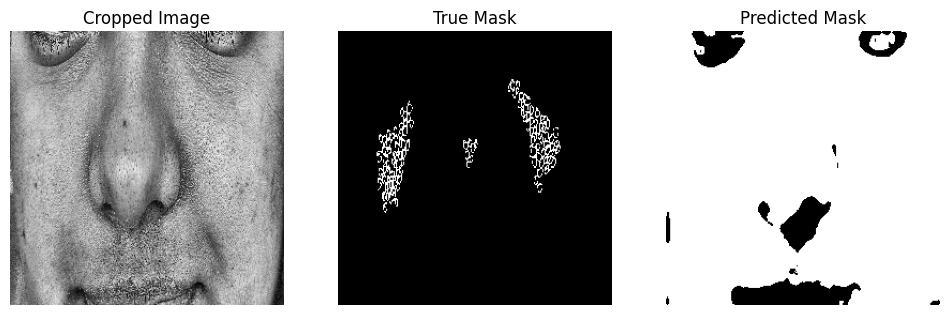

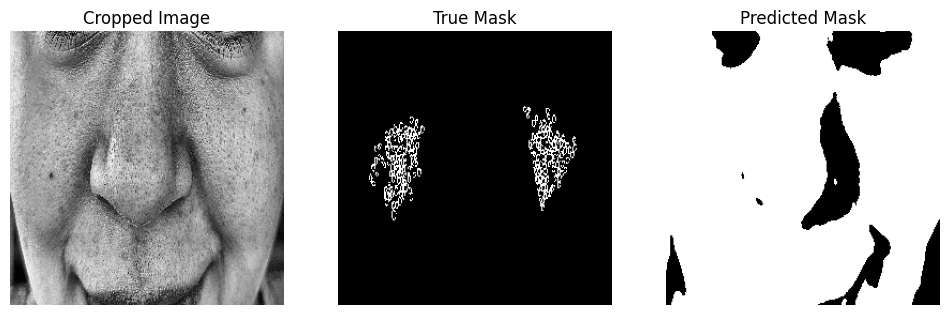

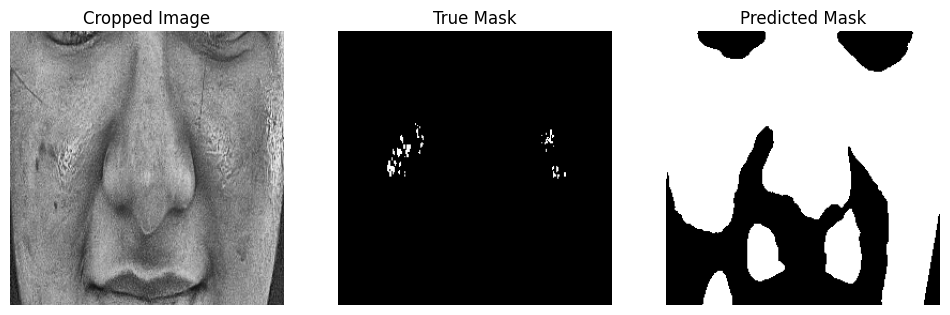

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


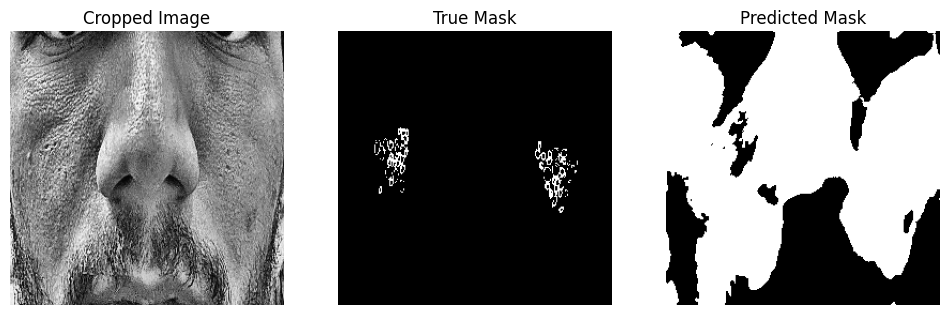

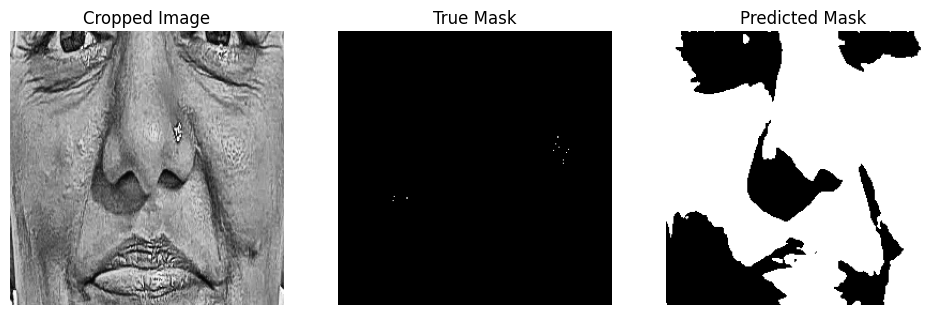

In [34]:
import matplotlib.pyplot as plt
import numpy as np

for images, masks in val_dataset.take(5):  # Show 5 batches
    preds = model.predict(images)
    for i in range(images.shape[0]):  # For each image in the batch
        img = images[i].numpy()
        true_mask = masks[i].numpy().squeeze()
        pred_mask = preds[i].squeeze()
        # If your model outputs values in [0,1], you may want to threshold
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img.squeeze(), cmap='gray' if img.shape[-1]==1 else None)
        plt.title("Cropped Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

In [ ]:
# At inference time, for a new original image:
def crop_original_image_to_butterfly(image, landmarks, indices):
    h, w = image.shape[:2]
    butterfly_pts = get_landmark_coords(image, landmarks.landmark, indices)
    if butterfly_pts.size == 0:
        return None, None, None
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [butterfly_pts], 255)
    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
    cropped_image = image[y_min:y_max, x_min:x_max]
    bbox = (x_min, y_min, x_max, y_max)
    return cropped_image, bbox, mask

In [ ]:
def place_mask_on_original(original_image, pred_mask, bbox):
    x_min, y_min, x_max, y_max = bbox
    mask_full = np.zeros(original_image.shape[:2], dtype=pred_mask.dtype)
    mask_full[y_min:y_max, x_min:x_max] = pred_mask
    return mask_full

In [ ]:
mask = place_mask_on_original(image, pred_mask_bin, bbox)

ValueError: could not broadcast input array from shape (256,256) into shape (701,1405)